### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [12]:
!nvidia-smi

Thu Mar 20 09:31:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [11]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [13]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.93 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.4/112.6 GB disk)


**NOTE:** When training YOLO11, make sure your data is located in `{HOME}/datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. When downloading data from [Roboflow Universe](https://universe.roboflow.com/), use the YOLOv8 format.

In [14]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="ZSmPx6Hn9f6hxard1G1m")
project = rf.workspace("skin-disease-ysval").project("skin-disease-detection-s7zik")
version = project.version(1)
dataset = version.download("yolov11")


mkdir: cannot create directory ‘/content/datasets’: File exists
/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Skin-Disease-Detection-1 in yolov11:: 100%|██████████| 5694/5694 [00:01<00:00, 4586.51it/s]


**NOTE:** Make sure to run commands below to make dataset work with YOLO11 training.

In [16]:
!sed -i '$d' {dataset.location}/data.yaml   # Delete the last line
!sed -i '$d' {dataset.location}/data.yaml   # Delete the second-to-last line
!sed -i '$d' {dataset.location}/data.yaml   # Delete the third-to-last line

!echo 'test: ../test/images' >> {dataset.location}/data.yaml
!echo 'train: ../train/images' >> {dataset.location}/data.yaml
!echo 'val: ../valid/images' >> {dataset.location}/data.yaml

## Custom Training

In [4]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=10 imgsz=400 plots=True

[Errno 2] No such file or directory: '{HOME}'
/content
100% 18.4M/18.4M [00:00<00:00, 313MB/s]
Ultralytics 8.3.93 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/Skin-Disease-Detection-1/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=400, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, s

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [17]:
!ls {HOME}/runs/detect/train/

args.yaml					    PR_curve.png	   val_batch0_pred.jpg
confusion_matrix_normalized.png			    R_curve.png		   val_batch1_labels.jpg
confusion_matrix.png				    results.csv		   val_batch1_pred.jpg
events.out.tfevents.1742462132.991868c14152.4468.0  results.png		   val_batch2_labels.jpg
F1_curve.png					    train_batch0.jpg	   val_batch2_pred.jpg
labels_correlogram.jpg				    train_batch1.jpg	   weights
labels.jpg					    train_batch2.jpg
P_curve.png					    val_batch0_labels.jpg


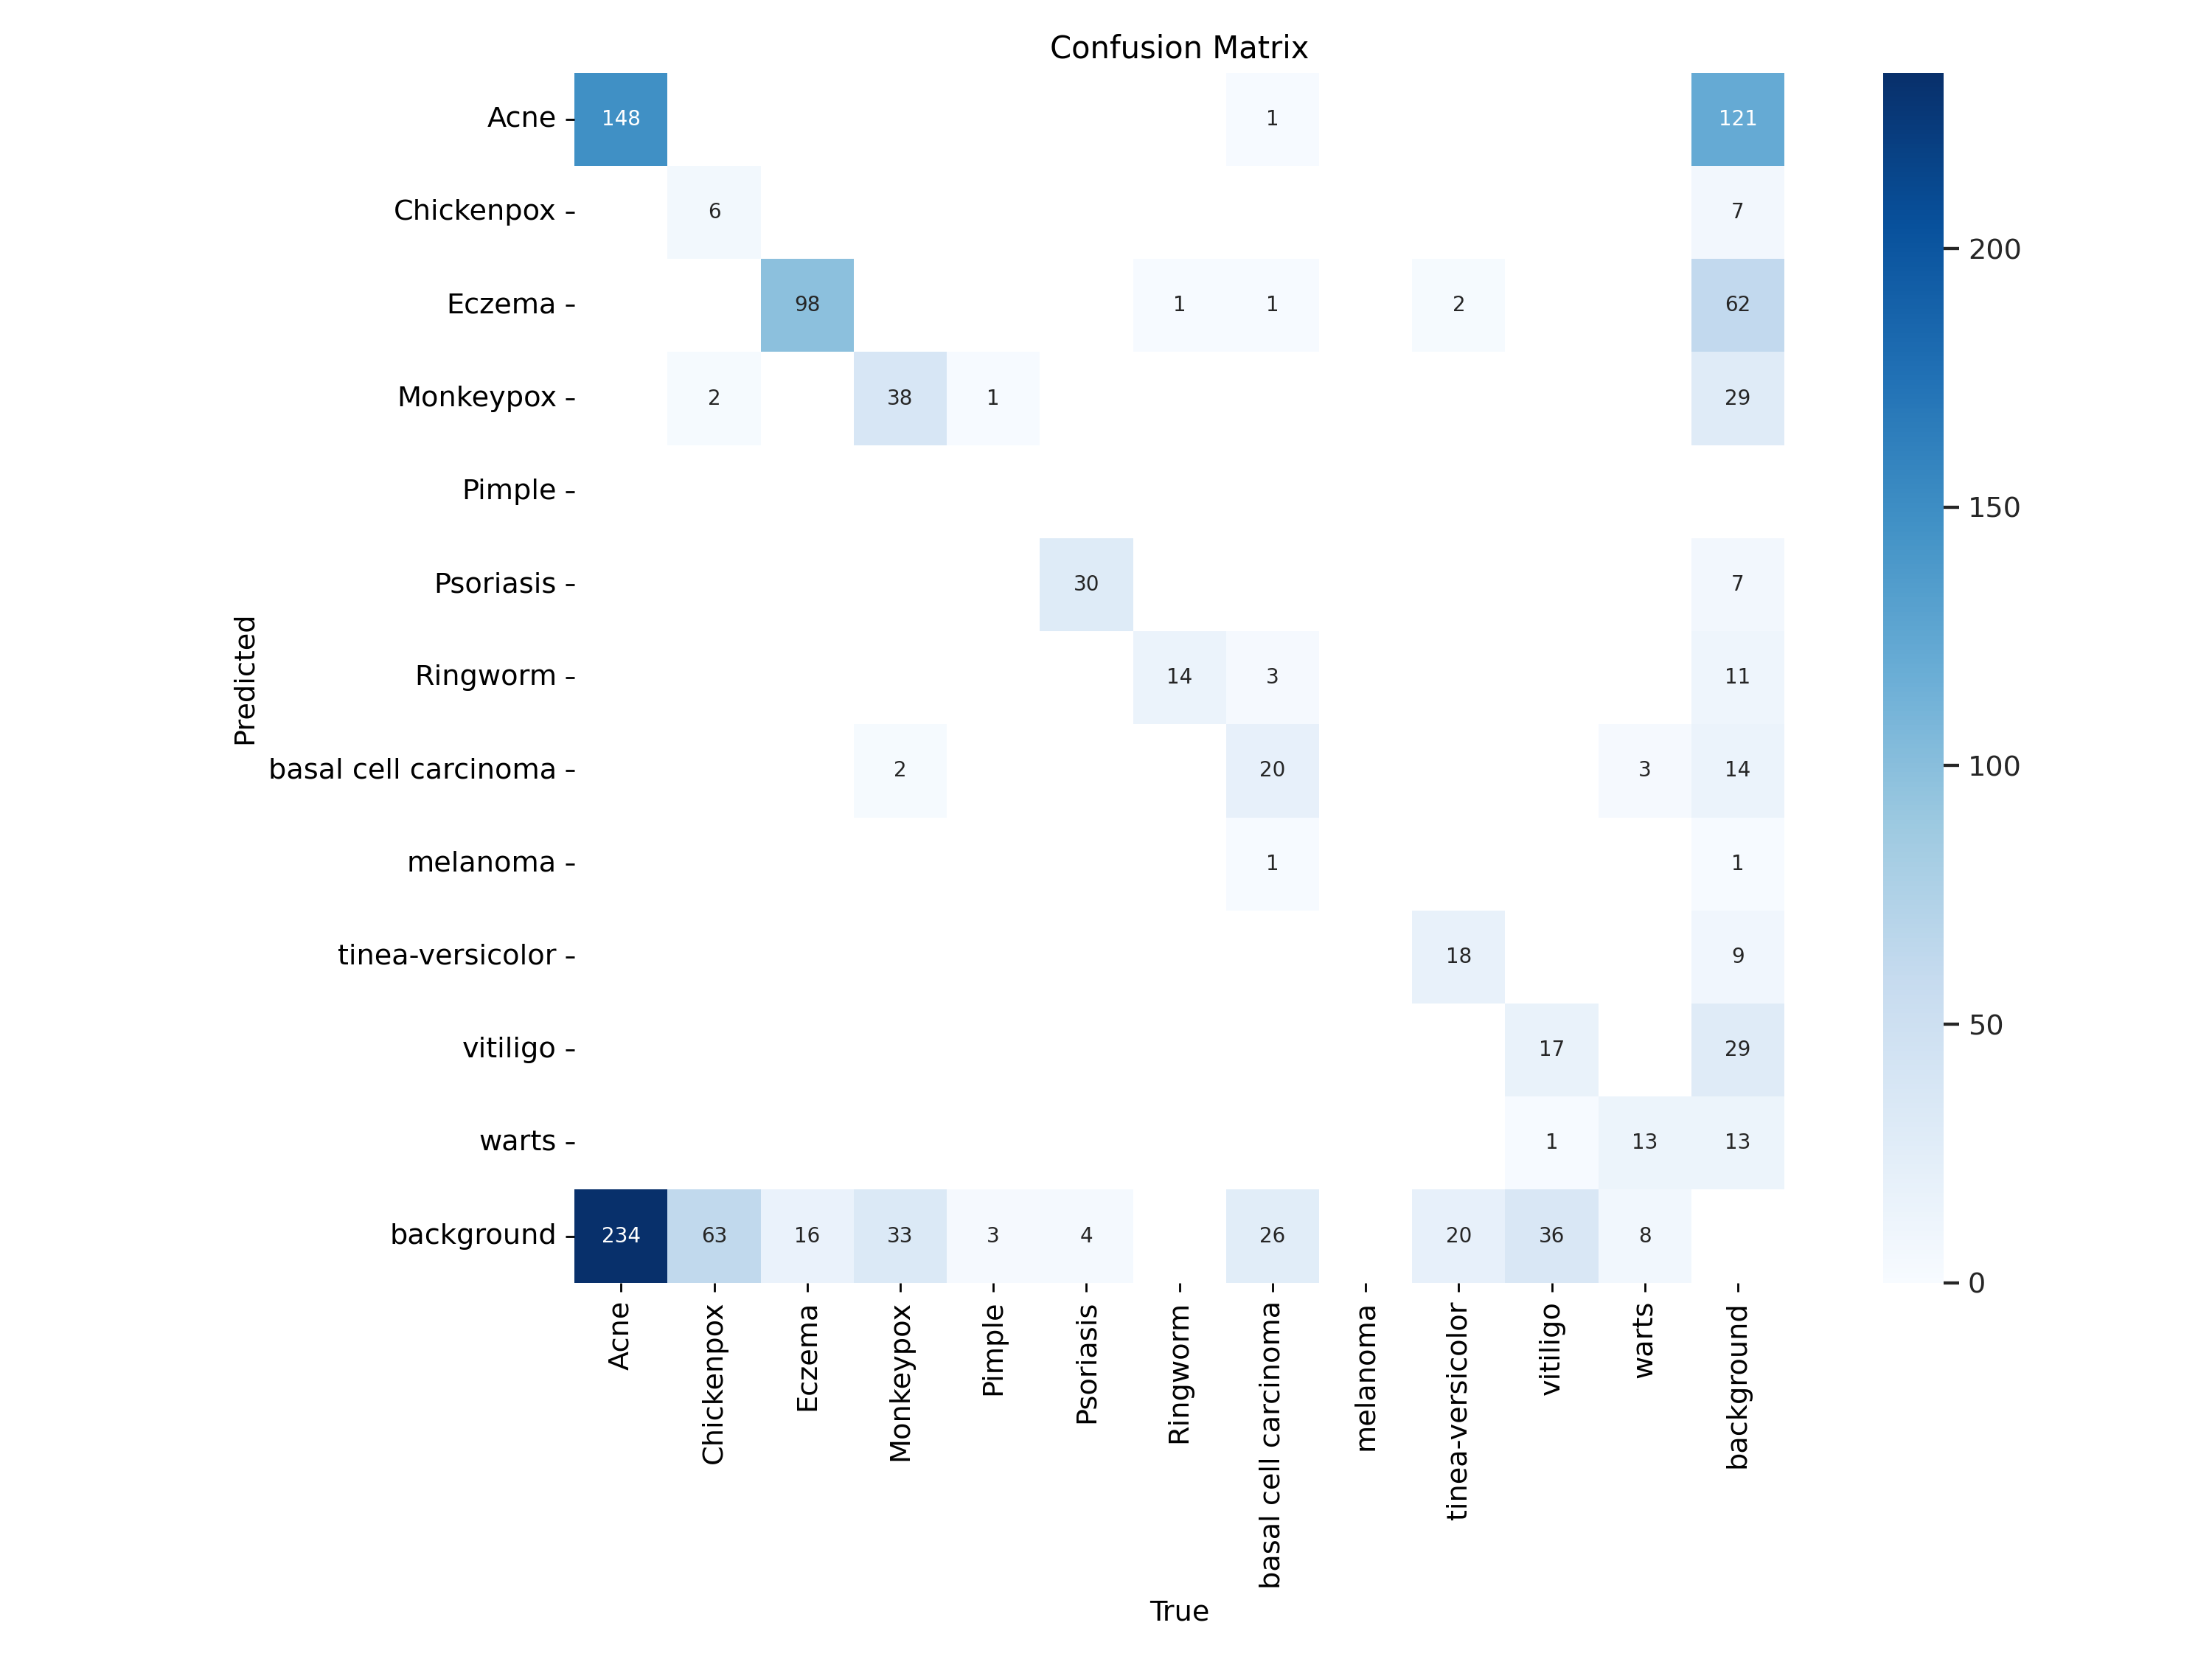

In [18]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

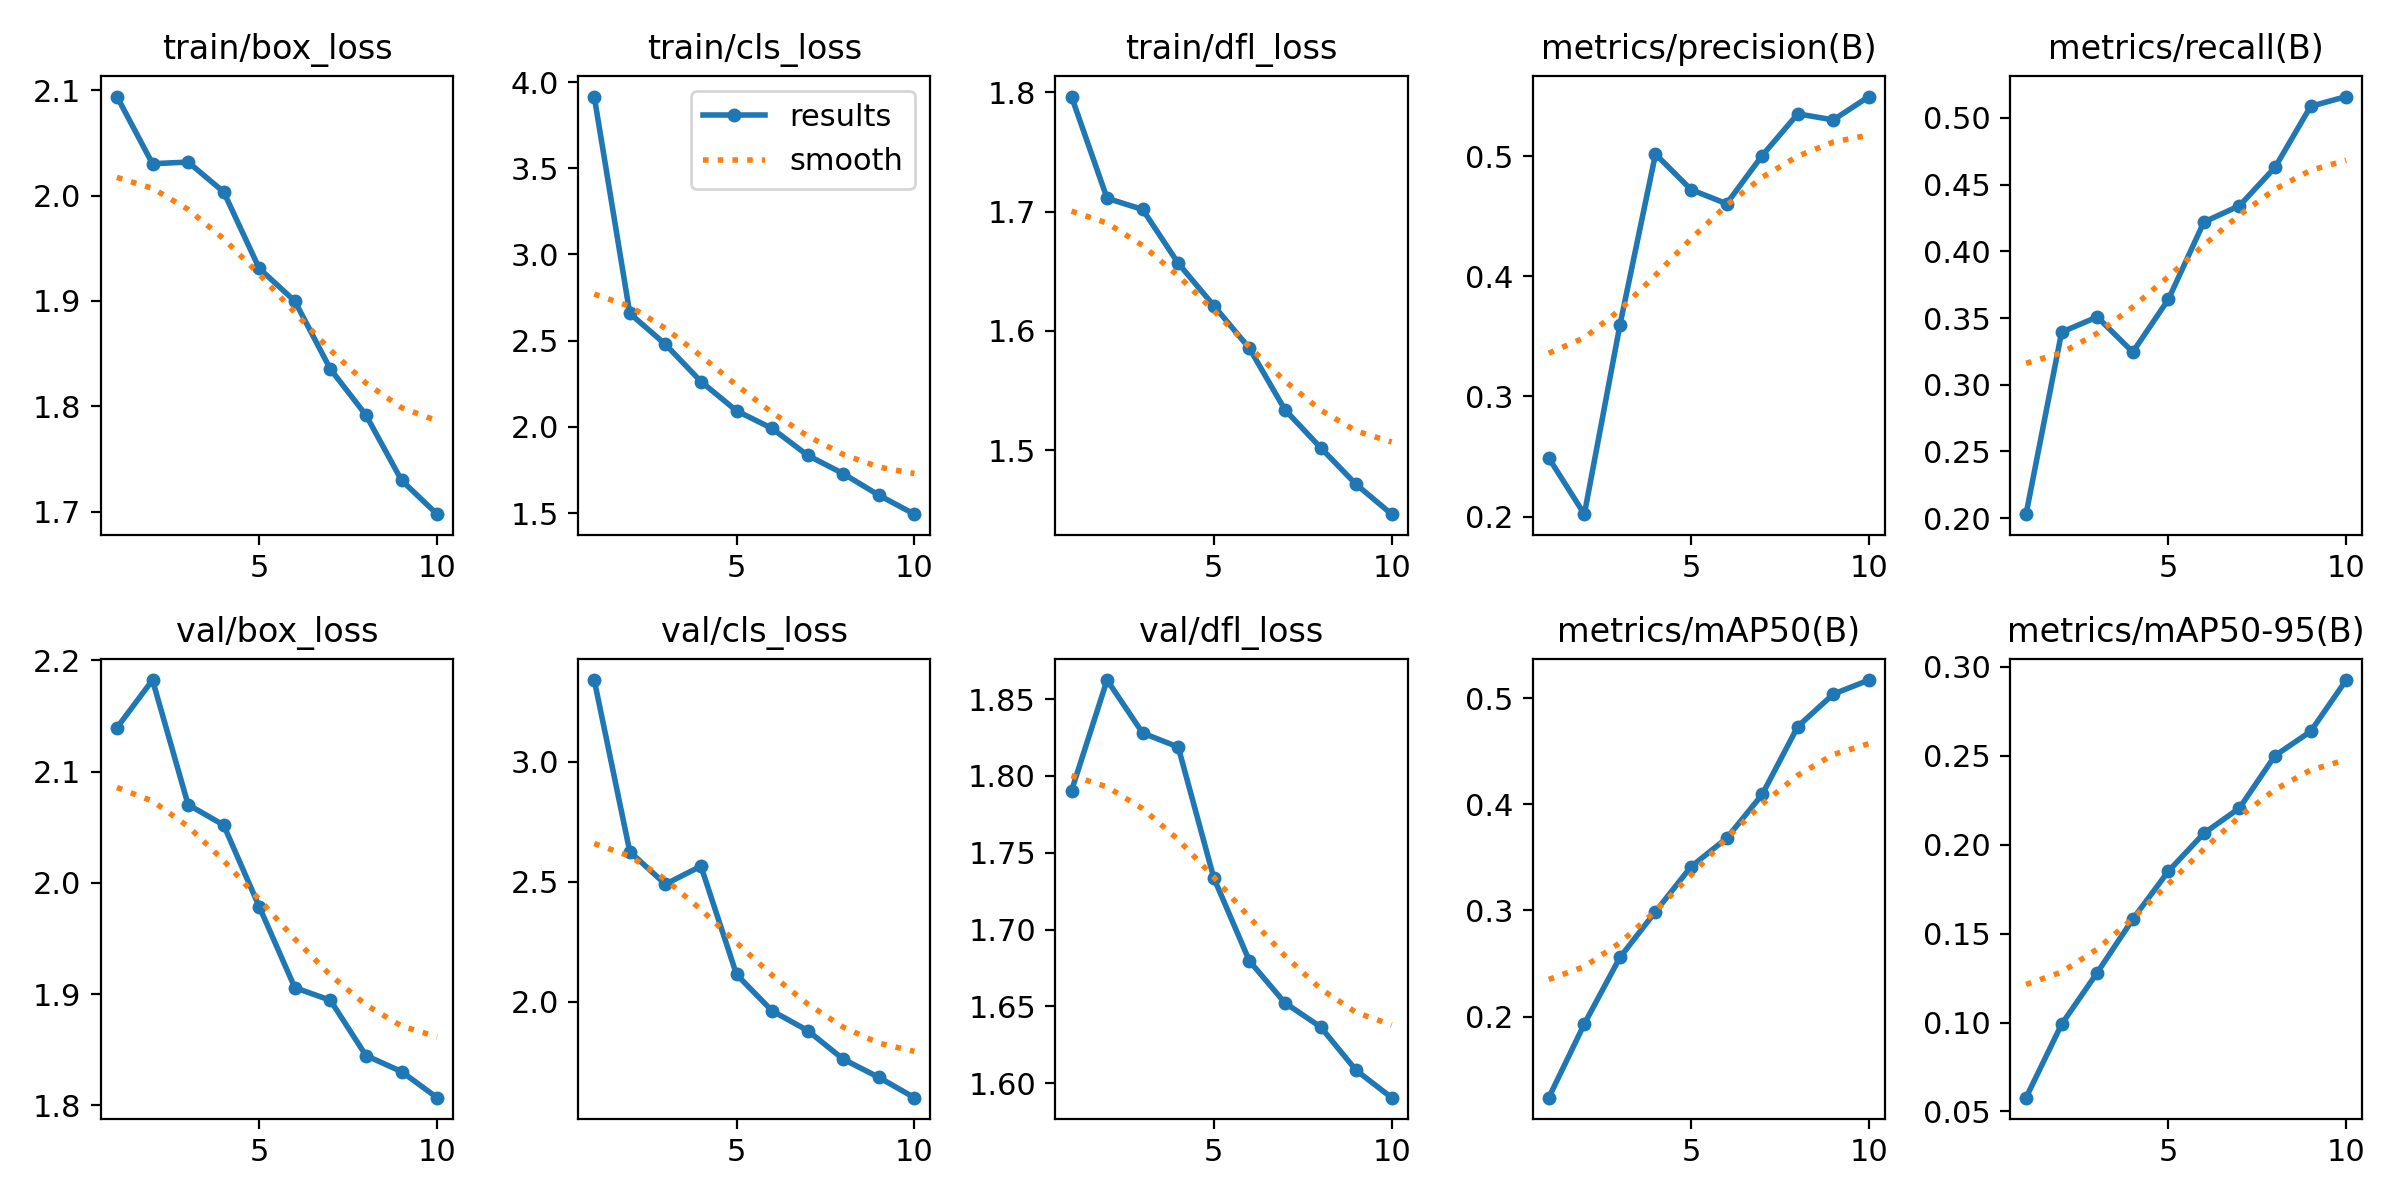

In [19]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

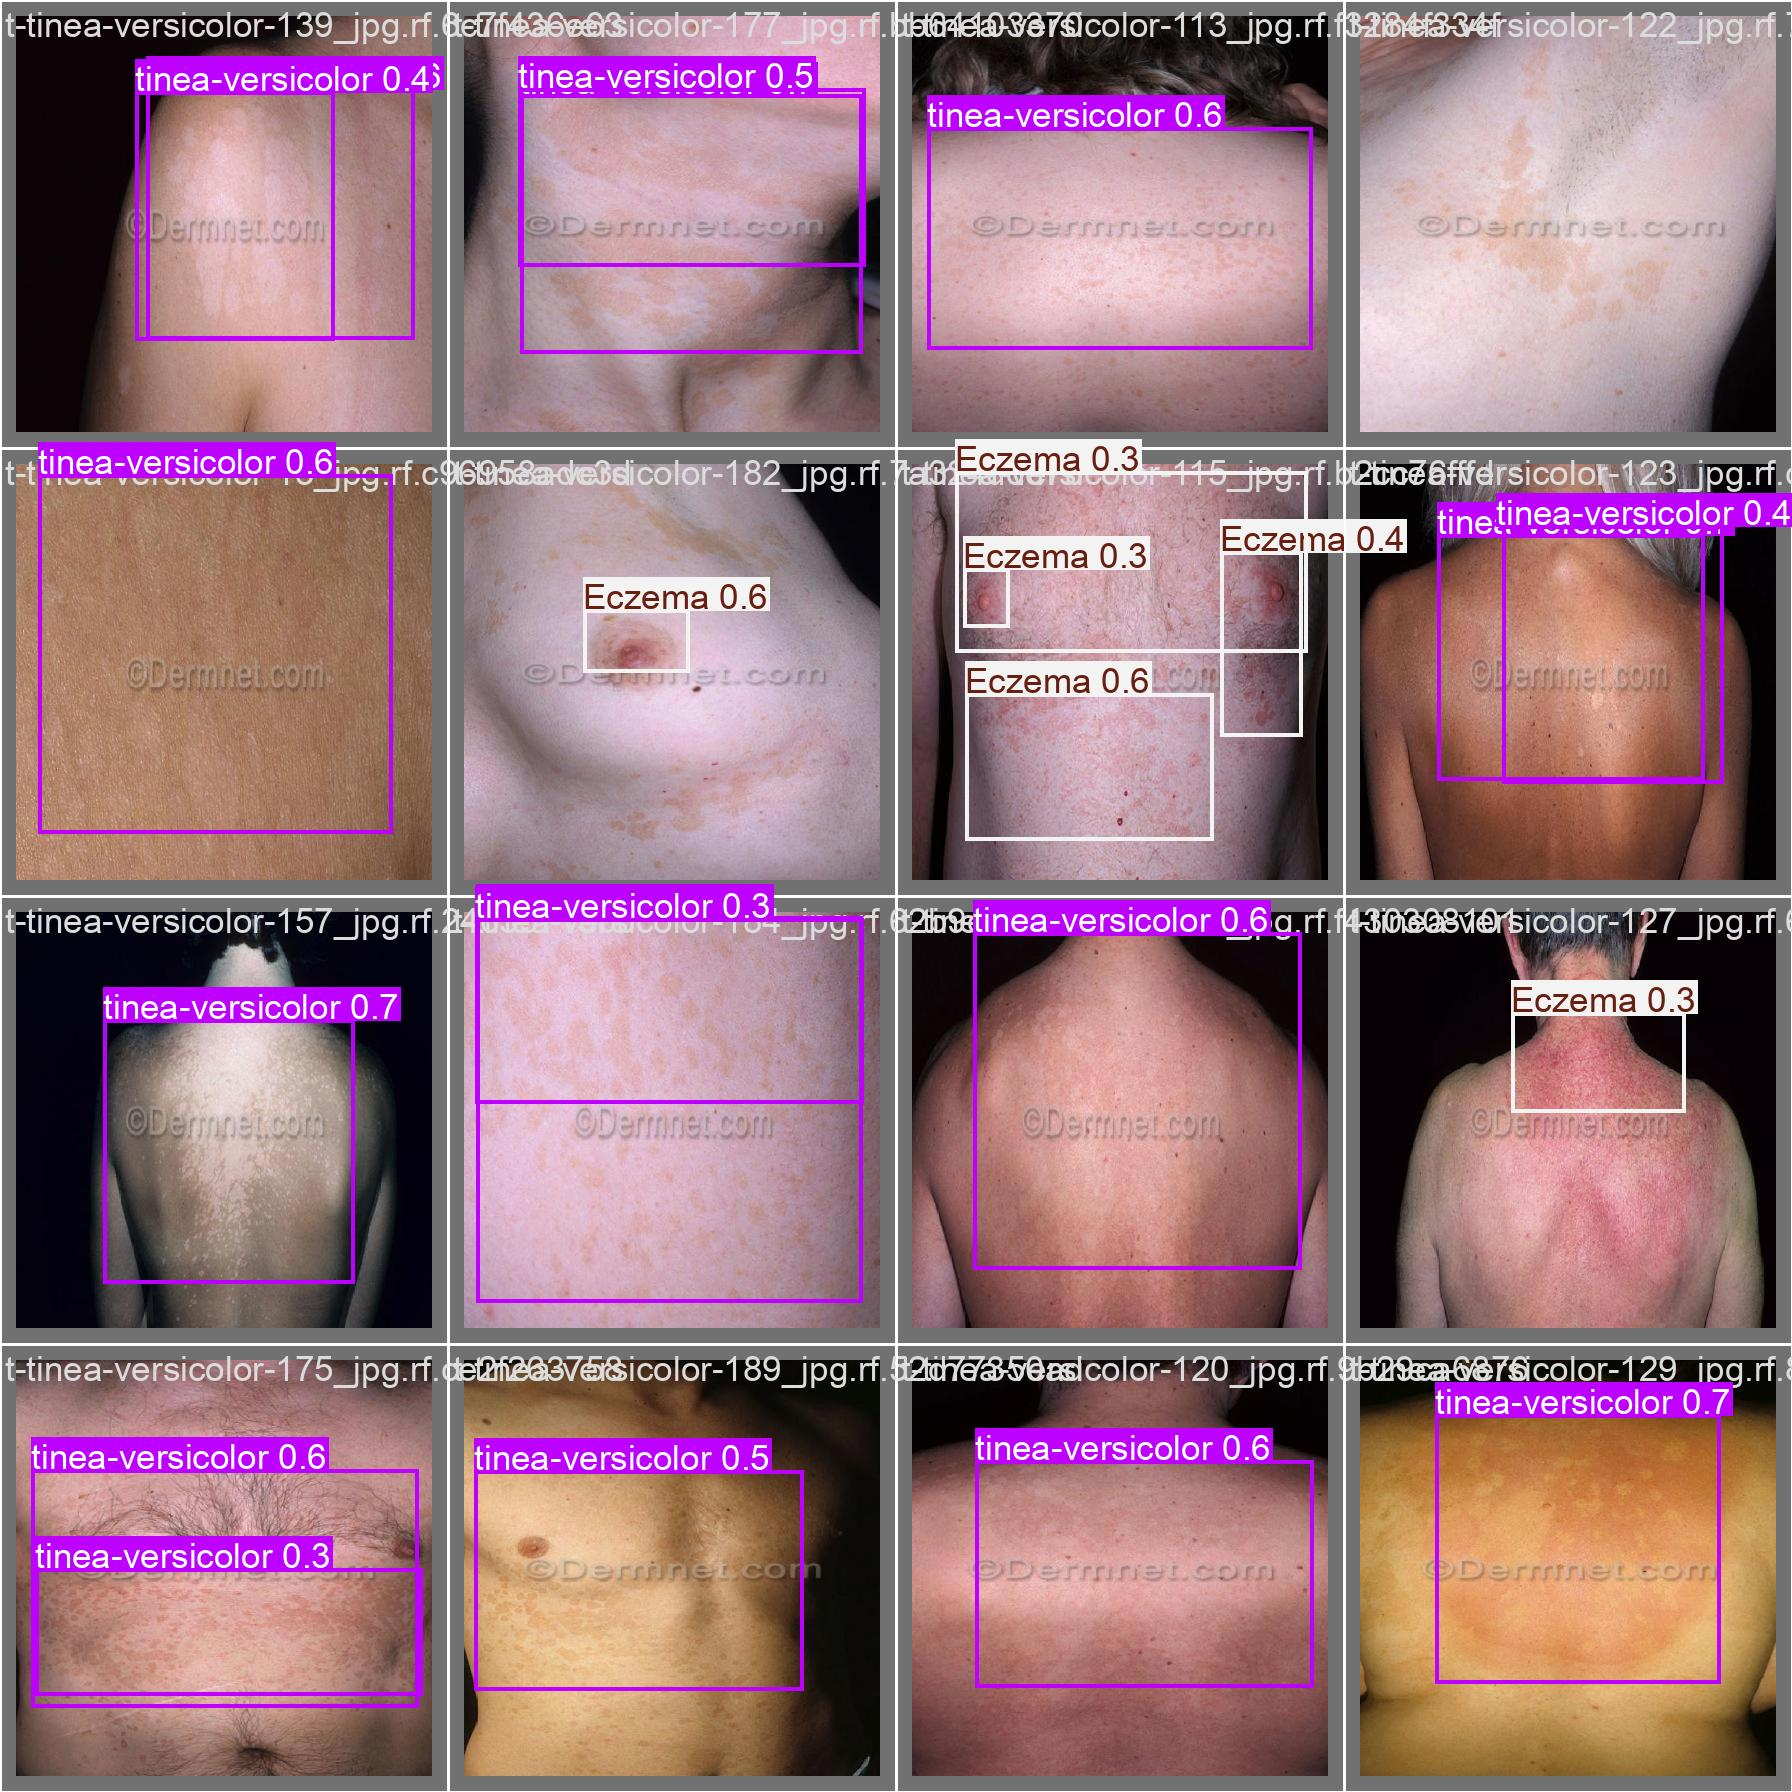

In [20]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [21]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.93 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,417,444 parameters, 0 gradients, 21.3 GFLOPs
val: Scanning /content/datasets/Skin-Disease-Detection-1/valid/labels... 264 images, 0 backgrounds, 0 corrupt: 100% 264/264 [00:00<00:00, 1688.30it/s]
val: New cache created: /content/datasets/Skin-Disease-Detection-1/valid/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 175, len(boxes) = 863. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 17/17 [00:04<00:00,  4.23it/s]
                   all        264        863      0.549      0.516      0.517      0.293
                  Acne         27        382      0.456      0.416      0.382      0.119
            Chickenpo

## Inference with custom model

In [ ]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.1 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,432,924 parameters, 0 gradients, 21.4 GFLOPs

image 1/44 /content/datasets/poker-cards-4/test/images/IMG_20220316_134701_jpg.rf.27aa29de9d6012ae05c64b156f7c07b8.jpg: 640x640 1 2 of spades, 1 3 of spades, 1 4 of spades, 1 ace of spades, 15.8ms
image 2/44 /content/datasets/poker-cards-4/test/images/IMG_20220316_135012_jpg.rf.ee7179374d33235528db011cb5418226.jpg: 640x640 1 2 of spades, 1 3 of spades, 1 4 of spades, 1 ace of spades, 15.8ms
image 3/44 /content/datasets/poker-cards-4/test/images/IMG_20220316_135021_jpg.rf.d038afdef1a927103dae268ff392888f.jpg: 640x640 1 2 of spades, 1 3 of spades, 1 4 of spades, 1 ace of spades, 15.8ms
image 4/44 /content/datasets/poker-cards-4/test/images/IMG_20220316_140241_jpg.rf.c44522806b5455bfb03a638aa3ffa896.jpg: 640x640 2 5 of spadess, 1 6 of spades, 2 7 of spadess, 1 8 of spades, 15.7ms
image 5/44 /content/datasets/poker-cards-4/tes

**NOTE:** Let's take a look at few results.

In [22]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob('/content/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

ValueError: max() arg is an empty sequence